In [1]:
import pandas as pd
from scipy import stats

def get_fisher_exact(s1, s2, sbk):
    n1 = len(s1 & s2 & sbk)
    n2 = len(s1 & (sbk - s2))
    n3 = len((sbk - s1) & s2)
    n4 = len((sbk - s1) & (sbk - s2))

    mat = [[n1, n2], [n3, n4]]

    oddsratio, pvalue = stats.fisher_exact(mat, 'greater')
    return oddsratio, pvalue

In [2]:
df_deg = pd.read_csv('./GSE150903_analysis/seurat_markers.csv')
df_deg.head()

,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
COL3A1,0.0,4.085408,0.917,0.084,0.0,ChP stroma,COL3A1
COL1A1,0.0,4.024959,0.948,0.092,0.0,ChP stroma,COL1A1
MGP,0.0,3.819090,0.594,0.074,0.0,ChP stroma,MGP
COL1A2,0.0,3.342141,0.969,0.247,0.0,ChP stroma,COL1A2
LGALS1,0.0,3.029331,0.978,0.390,0.0,ChP stroma,LGALS1


In [3]:
all_genes = set(df_deg.index)
pathway2genes = {c: set(df[(df.avg_logFC > 0.25) & (df.p_val_adj < 0.05)].gene) for c, df in df_deg.groupby('cluster')}

In [4]:
df_mk = pd.read_csv('./markers/seurat_markers.csv')

In [5]:
df_mk.head()

,Unnamed: 0,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
0,SLC1A2,0.0,2.917139,0.995,0.251,0.0,Ast1,SLC1A2
1,ADGRV1,0.0,2.753823,0.994,0.285,0.0,Ast1,ADGRV1
2,GPC5,0.0,2.453697,0.994,0.308,0.0,Ast1,GPC5
3,NKAIN3,0.0,2.024368,0.971,0.184,0.0,Ast1,NKAIN3
4,GPM6A,0.0,1.967135,0.999,0.513,0.0,Ast1,GPM6A


In [6]:
df_deg[df_deg.cluster == 'ChP stroma']

,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
COL3A1,0.000000e+00,4.085408,0.917,0.084,0.000000,ChP stroma,COL3A1
COL1A1,0.000000e+00,4.024959,0.948,0.092,0.000000,ChP stroma,COL1A1
MGP,0.000000e+00,3.819090,0.594,0.074,0.000000,ChP stroma,MGP
COL1A2,0.000000e+00,3.342141,0.969,0.247,0.000000,ChP stroma,COL1A2
LGALS1,0.000000e+00,3.029331,0.978,0.390,0.000000,ChP stroma,LGALS1
...,...,...,...,...,...,...,...
ARRDC3,1.608044e-07,-0.269655,0.244,0.269,0.000619,ChP stroma,ARRDC3
AP1S1,4.831928e-07,-0.256739,0.466,0.447,0.001861,ChP stroma,AP1S1
CKS2,1.046426e-06,-0.273297,0.283,0.306,0.004030,ChP stroma,CKS2
MT1X,2.768471e-06,-0.296099,0.091,0.118,0.010661,ChP stroma,MT1X


In [7]:
import glob 

id2key = sorted(pathway2genes)
res = []
id2ct = []
#for fn in sorted(glob.glob('./*_mk.csv')):
for ct, df in df_mk.groupby('cluster'):
    df = df[df.p_val_adj < 0.05]
    df = df.sort_values('avg_logFC', ascending=False,).iloc[:50]
    sgenes = set(df.gene) & all_genes
    vec = []
    for p in id2key:
        gs = pathway2genes[p]
        oddr, pval = get_fisher_exact(gs, sgenes, all_genes)
        vec.append(pval)
    res.append(vec)
    id2ct.append(ct)

In [8]:
df_mk

,Unnamed: 0,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
0,SLC1A2,0.000000,2.917139,0.995,0.251,0.0,Ast1,SLC1A2
1,ADGRV1,0.000000,2.753823,0.994,0.285,0.0,Ast1,ADGRV1
2,GPC5,0.000000,2.453697,0.994,0.308,0.0,Ast1,GPC5
3,NKAIN3,0.000000,2.024368,0.971,0.184,0.0,Ast1,NKAIN3
4,GPM6A,0.000000,1.967135,0.999,0.513,0.0,Ast1,GPM6A
...,...,...,...,...,...,...,...,...
26864,FNDC3A.6,0.005276,0.334872,0.521,0.631,1.0,Peri2,FNDC3A
26865,THRAP3.2,0.006601,0.287699,0.404,0.471,1.0,Peri2,THRAP3
26866,LIMS1.7,0.007603,0.376924,0.389,0.435,1.0,Peri2,LIMS1
26867,TAF3.1,0.008952,0.281138,0.296,0.399,1.0,Peri2,TAF3


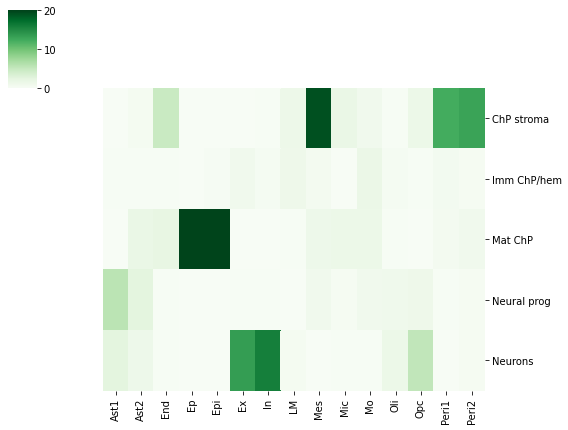

In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(-np.log10(np.array(res)))
df.columns = id2key
df.index = id2ct
sns.clustermap(df.T, vmax = 20, cmap = 'Greens', 
               col_cluster=False, row_cluster=False, 
               figsize = (8, 6))
plt.savefig("figs/enrichment_chp.pdf")

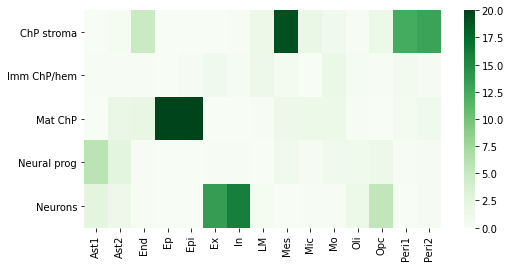

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize = (8, 4))
sns.heatmap(df.T, vmax = 20, cmap = 'Greens', ax = ax)
plt.savefig("figs/enrichment_chp.pdf")